This is an exercise to analyse data and build a prediction model from the UCI Repository's [bike sharing data](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).



In [ ]:
import pandas as pd

# Load the data into a DataFrame, parsing dteday as a date and using it as the index column
df = pd.read_csv('data/bike sharing/day.csv', parse_dates=['dteday'], index_col='dteday')

# Display the first few rows to make sure the data is loaded correctly
print(df.head())

# Separate the last 30 days into another DataFrame
condition = df.index <= df.index.max() - pd.Timedelta(days=30)
last_30_days = df[~condition]
df = df[condition]

# Display the number of rows of each DataFrame
print("Number of rows: main:", df.shape[0], "| last 30 days:", last_30_days.shape[0])


            instant  season  yr  mnth  holiday  weekday  workingday  \
dteday                                                                
2011-01-01        1       1   0     1        0        6           0   
2011-01-02        2       1   0     1        0        0           0   
2011-01-03        3       1   0     1        0        1           1   
2011-01-04        4       1   0     1        0        2           1   
2011-01-05        5       1   0     1        0        3           1   

            weathersit      temp     atemp       hum  windspeed  casual  \
dteday                                                                    
2011-01-01           2  0.344167  0.363625  0.805833   0.160446     331   
2011-01-02           2  0.363478  0.353739  0.696087   0.248539     131   
2011-01-03           1  0.196364  0.189405  0.437273   0.248309     120   
2011-01-04           1  0.200000  0.212122  0.590435   0.160296     108   
2011-01-05           1  0.226957  0.229270  0.436957

### Data processing and analysis

Assuming each bike has a maximum of 12 rentals per day, I determined both the maximum number and the 95%-percentile of bicycles that was needed in a day.

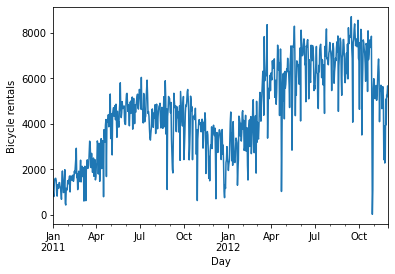

Maximum bicycles needed: 727
95% percentile: 632


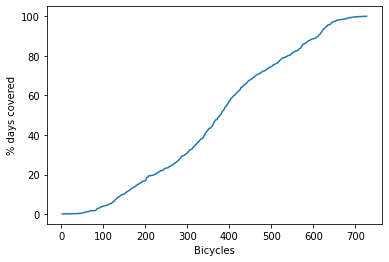

In [ ]:
from math import ceil
import matplotlib.pyplot as plt

# Prevent leakage: these fields presumably wouldn't be available at prediction time
main_df = df.drop(columns=['casual', 'registered'])

# Drop `instant`, which is not a feature
main_df.drop(columns='instant', inplace=True)

# Add day (of month) column
main_df['day'] = main_df.index.map(lambda x: x.day)

# Visualise rentals of bikes per day
axis = main_df['cnt'].plot()
axis.set(xlabel='Day', ylabel='Bicycle rentals')
plt.show()

# Find the number of bicycles needed
max_rentals_per_bicycle = 12
bicycles_needed = main_df['cnt'].apply(lambda x: ceil(x / max_rentals_per_bicycle))
nmax = bicycles_needed.max()
print("Maximum bicycles needed:", nmax)
n95 = bicycles_needed.quantile(0.95, interpolation='lower')
print("95% percentile:", n95)

# Visualise how many days would be covered by some given number of bicycles
bicycle_needed_counts = bicycles_needed.value_counts().sort_index()
bicycle_needed_coverage = 100 * bicycle_needed_counts.cumsum() / bicycles_needed.shape[0]
axis = bicycle_needed_coverage.plot()
axis.set(xlabel="Bicycles", ylabel="% days covered")
plt.show()

### Build prediction model

- For splitting into training and test sets, I made sure test set is after training set as we can't see the future in the real world. If one doesn't have that much data, a larger test set is typically better. I considered even going up to a 50-50 split to measure the accuracy across various seasons. But I decided to not make the test set too large as the training data would be fairly old in that case, as this is a fairly fast-changing domain. Looking at the data, I see that 2012 has significantly more rentals than 2011, so it would be hard for the model to learn this if it didn't include a significant amount of data from 2012.

  Another way to possibly deal with the above might be to represent the demand for some given day as a percentage of the moving average over the last few days (or some other measure based on recent data) and try to predict that instead.

- The metric I selected to measure accuracy was Mean Absolute Error.

  Assuming we are renting out the bicycles, every bicycle our prediction is from the actual bicycles requested would correlate roughly linearly to the amount of money lost. Predicting more than the actual might mean paying for unused supply. Predicting less than the actual might mean not having enough supply and losing out on the profit from being unable to fulfil a request to rent a bicycle. This also damages our reputation and means the user is less likely to use the service again (for which it may make sense to consider the number of registered users and possibly predict the lifetime value of a user).
 
  Depending on the profit margins, weighting over- and underprediction differently might make sense, but evenly weighting them with Mean Absolute Error seems like a reasonable starting point.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Split into training and test
condition = main_df.index < '2012-08'
train_df = main_df[condition]
test_df = main_df[~condition]
print("Training set size:", train_df.shape[0], "| test set size:", test_df.shape[0],
      "| test fraction:", test_df.shape[0] / (train_df.shape[0] + test_df.shape[0]))

# Separate label from features
train_y = train_df['cnt']
train_X = train_df.drop(columns='cnt')
test_y = test_df['cnt']
test_X = test_df.drop(columns='cnt')

model = RandomForestRegressor()

model.fit(train_X, train_y)

predict_y = model.predict(test_X)
print("Mean absolute error:", mean_absolute_error(test_y, predict_y))

Training set size: 578 | test set size: 123 | test fraction: 0.1754636233951498
Mean absolute error: 915.9591869918698


### Fine-tune model with grid search

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import numpy as np

# Use 3 splits instead of the default of 5 since we don't have much data
cross_validator = TimeSeriesSplit(n_splits=3)

search_parameters = {
    # 100 estimators is the default, but fewer may make sense since we don't have that much data (also try more just in case)
    'n_estimators': [5, 10, 20, 50, 100, 150, 200],
    # mse is the default criterion, but we're scoring it on mae, so try both
    'criterion': ['mse', 'mae'],
    # requiring more samples at leaves means it generalises more, but don't make it too high as we don't have much data
    'min_samples_leaf': list(range(1, 5)),
    # this serves a similar purpose to min_samples_leaf, but it could be worth optimising on both
    'min_samples_split': list(range(2, 7)),
    # we don't have that many features, so consider either all of them or half of them
    'max_features': ['auto', 1/2],
}

cv_model = GridSearchCV(estimator=RandomForestRegressor(), param_grid=search_parameters,
                              scoring='neg_mean_absolute_error',
                              cv=cross_validator, verbose=5, n_jobs=-1)
cv_model.fit(train_X, train_y)

predict_y = cv_model.predict(test_X)
print("Mean absolute error:", mean_absolute_error(test_y, predict_y))
print("Best parameters:", cv_model.best_params_)

Fitting 3 folds for each of 560 candidates, totalling 1680 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  3.3min
Mean absolute error: 861.6385494902569
Best parameters: {'criterion': 'mse', 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:  3.9min finished


### Optimise (revenue - cost) by adapting number of bicycles

In [ ]:
# A single rental from the service the data comes from costs $2 for 0-29 min, $4 for 30-59 min, etc. I'll assume the average is around $3.
revenue_per_rental = 3
# An inexpensive bicycle costs about $600 (in the US, where the data is from). Between the maintenance cost, vandalism and theft,
# I'll assume this works out to a cost equivalent to replacing the bike every 2 months. That's about 600/60 = $10 per day.
cost_per_day = 10

def predicted_profit(bikes, data, simulations=10):
    # Run a few simulations and take the average
    profit_sum = 0
    for _ in range(simulations):
        # Based on optimised hyperparameters
        model = RandomForestRegressor(criterion='mse', max_features=0.5, min_samples_leaf=1,
                                      min_samples_split=5, n_estimators=5)
        model.fit(train_X, train_y)
        residuals = test_y - model.predict(test_X)
        predicted_demand = pd.Series(model.predict(data))
        demand = predicted_demand + np.random.normal(residuals.mean(), residuals.std(), predicted_demand.size)
        # Avoid negative values and fractions as these don't make sense for demand
        demand = demand.apply(lambda x: round(max(x, 0)))

        total_cost = bikes * cost_per_day * predicted_demand.size
        total_revenue = revenue_per_rental * demand.apply(lambda x: min(x, max_rentals_per_bicycle * bikes)).sum()
        profit_sum += total_revenue - total_cost
    return profit_sum / simulations

last_30_days_X = last_30_days.drop(columns=['cnt', 'casual', 'registered'])

print("Profit for max (", nmax, ") bicycles: $", predicted_profit(nmax, last_30_days_X))

# Find the optimal number of bikes to obtain the highest profit
best = 0, 0
for bikes in range(0, nmax, 10):
    profit = predicted_profit(bikes, last_30_days_X)
    if profit > best[1]:
        best = bikes, profit

print("Optimal number of bikes:", best[0], "| profit:", best[1])

Profit for max ( 727 ) bicycles: $ 307938.3
Optimal number of bikes: 630 | profit: 362155.2
